## Demo of 1D regression with an Attentive Neural Process (ANP) model

This notebook will provide a simple and straightforward demonstration on how to utilize an Attentive Neural Process (ANP) to regress context and target points to a sine curve.

First, we need to import all necessary packages and modules for our task:

In [13]:
import os
import sys
import torch
from matplotlib import pyplot as plt

# Provide access to modules in repo.
sys.path.insert(0, os.path.abspath('neural_process_models'))
sys.path.insert(0, os.path.abspath('misc'))

from neural_process_models.attentive_neural_process import NeuralProcessModel
from misc.test_sin_regression.Sin_Wave_Data import sin_wave_data, plot_functions

The `sin_wave_data` class, defined in `misc/test_sin_regression/Sin_Data_Wave.py`, represents the curve that we will try to regress to. From instances of this class, we are able to sample context and target points from the curve to serve as inputs for our neural process.

The default parameters of this class will produce a "ground truth" curve defined as the sum of the following:
1. A sine curve with amplitude 1, frequency 1, and phase 1.
2. A sine curve with amplitude 2, frequency 2, and phase 1.
3. A measured amount of noise (0.1).

Let us create an instance of this class:

In [14]:
data = sin_wave_data()

Next, we need to instantiate our model. The ANP model is implemented under the `NeuralProcessModel` class under the file `neural_process_models/attentive_neural_process.py`.

We will use the following parameters for our example model:
* 1 for x-dimension and y-dimension (since this is 1D regression)
* 4 hidden layers of dimension 256 for encoders and decoder
* 256 as the latent dimension for encoders and decoder
* We will utilize a self-attention process.
* We will utilize a deterministic path for the encoder.

Let us create an instance of this class, as well as set some hyperparameters for our training:

In [15]:
np_model = NeuralProcessModel(x_dim=1,
                              y_dim=1,
                              mlp_hidden_size_list=[256, 256, 256, 256],
                              latent_dim=256,
                              use_rnn=False,
                              use_self_attention=True,
                              use_deter_path=True)

optim = torch.optim.Adam(np_model.parameters(), lr=1e-4)
num_epochs = 1000
batch_size = 16

Now, let us train our model. For each epoch, we will print the loss at that epoch. Here is a GIF displaying the regression results over the duration of training:

![SegmentLocal](misc/images/anp_-3_3.gif "results")

Additionally, every 100 epochs, an image will be generated and displayed, using `pyplot`. This will give you an opportunity to more closely analyze and/or save the images, if you would like.

step = 1
loss =  tensor(2.9210, grad_fn=<NegBackward>)
step = 2
loss =  tensor(2.8882, grad_fn=<NegBackward>)
step = 3
loss =  tensor(2.8863, grad_fn=<NegBackward>)
step = 4
loss =  tensor(2.8463, grad_fn=<NegBackward>)
step = 5
loss =  tensor(2.8247, grad_fn=<NegBackward>)
step = 6
loss =  tensor(2.8065, grad_fn=<NegBackward>)
step = 7
loss =  tensor(2.7766, grad_fn=<NegBackward>)
step = 8
loss =  tensor(2.7629, grad_fn=<NegBackward>)
step = 9
loss =  tensor(2.7060, grad_fn=<NegBackward>)
step = 10
loss =  tensor(2.6521, grad_fn=<NegBackward>)
step = 11
loss =  tensor(2.6074, grad_fn=<NegBackward>)
step = 12
loss =  tensor(2.5687, grad_fn=<NegBackward>)
step = 13
loss =  tensor(2.4976, grad_fn=<NegBackward>)
step = 14
loss =  tensor(2.4209, grad_fn=<NegBackward>)
step = 15
loss =  tensor(2.3352, grad_fn=<NegBackward>)
step = 16
loss =  tensor(2.2302, grad_fn=<NegBackward>)
step = 17
loss =  tensor(2.1356, grad_fn=<NegBackward>)
step = 18
loss =  tensor(2.0382, grad_fn=<NegBackward>)
s

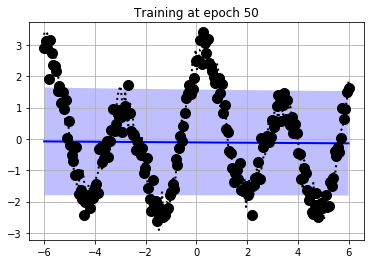

step = 51
loss =  tensor(1.8721, grad_fn=<NegBackward>)
step = 52
loss =  tensor(1.8718, grad_fn=<NegBackward>)
step = 53
loss =  tensor(1.8683, grad_fn=<NegBackward>)
step = 54
loss =  tensor(1.8673, grad_fn=<NegBackward>)
step = 55
loss =  tensor(1.8628, grad_fn=<NegBackward>)
step = 56
loss =  tensor(1.8561, grad_fn=<NegBackward>)
step = 57
loss =  tensor(1.8605, grad_fn=<NegBackward>)
step = 58
loss =  tensor(1.8679, grad_fn=<NegBackward>)
step = 59
loss =  tensor(1.8602, grad_fn=<NegBackward>)
step = 60
loss =  tensor(1.8672, grad_fn=<NegBackward>)
step = 61
loss =  tensor(1.8637, grad_fn=<NegBackward>)
step = 62
loss =  tensor(1.8624, grad_fn=<NegBackward>)
step = 63
loss =  tensor(1.8563, grad_fn=<NegBackward>)
step = 64
loss =  tensor(1.8668, grad_fn=<NegBackward>)
step = 65
loss =  tensor(1.8597, grad_fn=<NegBackward>)
step = 66
loss =  tensor(1.8577, grad_fn=<NegBackward>)
step = 67
loss =  tensor(1.8588, grad_fn=<NegBackward>)
step = 68
loss =  tensor(1.8649, grad_fn=<NegBac

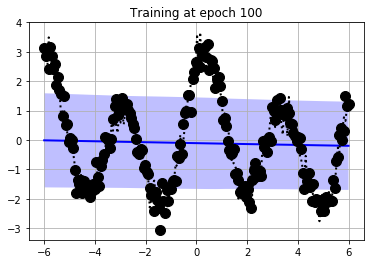

step = 101
loss =  tensor(1.8584, grad_fn=<NegBackward>)
step = 102
loss =  tensor(1.8527, grad_fn=<NegBackward>)
step = 103
loss =  tensor(1.8499, grad_fn=<NegBackward>)
step = 104
loss =  tensor(1.8562, grad_fn=<NegBackward>)
step = 105
loss =  tensor(1.8542, grad_fn=<NegBackward>)
step = 106
loss =  tensor(1.8607, grad_fn=<NegBackward>)
step = 107
loss =  tensor(1.8582, grad_fn=<NegBackward>)
step = 108
loss =  tensor(1.8483, grad_fn=<NegBackward>)
step = 109
loss =  tensor(1.8536, grad_fn=<NegBackward>)
step = 110
loss =  tensor(1.8558, grad_fn=<NegBackward>)
step = 111
loss =  tensor(1.8608, grad_fn=<NegBackward>)
step = 112
loss =  tensor(1.8480, grad_fn=<NegBackward>)
step = 113
loss =  tensor(1.8538, grad_fn=<NegBackward>)
step = 114
loss =  tensor(1.8597, grad_fn=<NegBackward>)
step = 115
loss =  tensor(1.8548, grad_fn=<NegBackward>)
step = 116
loss =  tensor(1.8456, grad_fn=<NegBackward>)
step = 117
loss =  tensor(1.8493, grad_fn=<NegBackward>)
step = 118
loss =  tensor(1.850

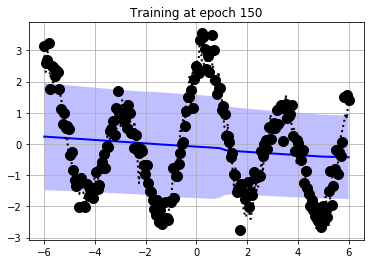

step = 151
loss =  tensor(1.8153, grad_fn=<NegBackward>)
step = 152
loss =  tensor(1.8178, grad_fn=<NegBackward>)
step = 153
loss =  tensor(1.8078, grad_fn=<NegBackward>)
step = 154
loss =  tensor(1.8163, grad_fn=<NegBackward>)
step = 155
loss =  tensor(1.8126, grad_fn=<NegBackward>)
step = 156
loss =  tensor(1.8121, grad_fn=<NegBackward>)
step = 157
loss =  tensor(1.8069, grad_fn=<NegBackward>)
step = 158
loss =  tensor(1.8119, grad_fn=<NegBackward>)
step = 159
loss =  tensor(1.8017, grad_fn=<NegBackward>)
step = 160
loss =  tensor(1.8037, grad_fn=<NegBackward>)
step = 161
loss =  tensor(1.8030, grad_fn=<NegBackward>)
step = 162
loss =  tensor(1.8012, grad_fn=<NegBackward>)
step = 163
loss =  tensor(1.8025, grad_fn=<NegBackward>)
step = 164
loss =  tensor(1.8000, grad_fn=<NegBackward>)
step = 165
loss =  tensor(1.8006, grad_fn=<NegBackward>)
step = 166
loss =  tensor(1.7979, grad_fn=<NegBackward>)
step = 167
loss =  tensor(1.7962, grad_fn=<NegBackward>)
step = 168
loss =  tensor(1.793

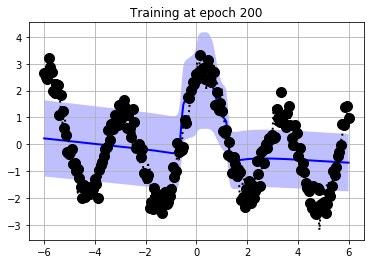

step = 201
loss =  tensor(1.6390, grad_fn=<NegBackward>)
step = 202
loss =  tensor(1.6296, grad_fn=<NegBackward>)
step = 203
loss =  tensor(1.6145, grad_fn=<NegBackward>)
step = 204
loss =  tensor(1.6151, grad_fn=<NegBackward>)
step = 205
loss =  tensor(1.6059, grad_fn=<NegBackward>)
step = 206
loss =  tensor(1.6135, grad_fn=<NegBackward>)
step = 207
loss =  tensor(1.6096, grad_fn=<NegBackward>)
step = 208
loss =  tensor(1.5958, grad_fn=<NegBackward>)
step = 209
loss =  tensor(1.5950, grad_fn=<NegBackward>)
step = 210
loss =  tensor(1.5787, grad_fn=<NegBackward>)
step = 211
loss =  tensor(1.5808, grad_fn=<NegBackward>)
step = 212
loss =  tensor(1.5795, grad_fn=<NegBackward>)
step = 213
loss =  tensor(1.5686, grad_fn=<NegBackward>)
step = 214
loss =  tensor(1.5729, grad_fn=<NegBackward>)
step = 215
loss =  tensor(1.5446, grad_fn=<NegBackward>)
step = 216
loss =  tensor(1.5510, grad_fn=<NegBackward>)
step = 217
loss =  tensor(1.5259, grad_fn=<NegBackward>)
step = 218
loss =  tensor(1.550

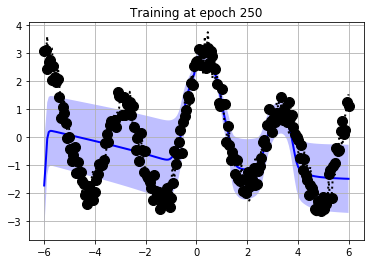

step = 251
loss =  tensor(1.2847, grad_fn=<NegBackward>)
step = 252
loss =  tensor(1.3117, grad_fn=<NegBackward>)
step = 253
loss =  tensor(1.3054, grad_fn=<NegBackward>)
step = 254
loss =  tensor(1.3201, grad_fn=<NegBackward>)
step = 255
loss =  tensor(1.3354, grad_fn=<NegBackward>)
step = 256
loss =  tensor(1.2745, grad_fn=<NegBackward>)
step = 257
loss =  tensor(1.3298, grad_fn=<NegBackward>)
step = 258
loss =  tensor(1.2699, grad_fn=<NegBackward>)
step = 259
loss =  tensor(1.3270, grad_fn=<NegBackward>)
step = 260
loss =  tensor(1.2918, grad_fn=<NegBackward>)
step = 261
loss =  tensor(1.2791, grad_fn=<NegBackward>)
step = 262
loss =  tensor(1.2861, grad_fn=<NegBackward>)
step = 263
loss =  tensor(1.2552, grad_fn=<NegBackward>)
step = 264
loss =  tensor(1.2771, grad_fn=<NegBackward>)
step = 265
loss =  tensor(1.2472, grad_fn=<NegBackward>)
step = 266
loss =  tensor(1.2509, grad_fn=<NegBackward>)
step = 267
loss =  tensor(1.2623, grad_fn=<NegBackward>)
step = 268
loss =  tensor(1.237

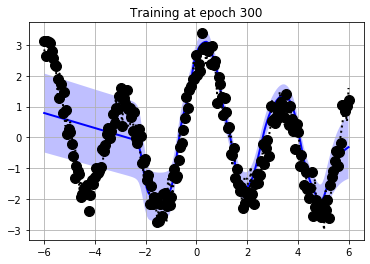

step = 301
loss =  tensor(0.9402, grad_fn=<NegBackward>)
step = 302
loss =  tensor(0.9421, grad_fn=<NegBackward>)
step = 303
loss =  tensor(1.0646, grad_fn=<NegBackward>)
step = 304
loss =  tensor(1.5072, grad_fn=<NegBackward>)
step = 305
loss =  tensor(1.3796, grad_fn=<NegBackward>)
step = 306
loss =  tensor(1.1755, grad_fn=<NegBackward>)
step = 307
loss =  tensor(1.2639, grad_fn=<NegBackward>)
step = 308
loss =  tensor(1.1933, grad_fn=<NegBackward>)
step = 309
loss =  tensor(1.0860, grad_fn=<NegBackward>)
step = 310
loss =  tensor(1.0397, grad_fn=<NegBackward>)
step = 311
loss =  tensor(1.0665, grad_fn=<NegBackward>)
step = 312
loss =  tensor(1.0957, grad_fn=<NegBackward>)
step = 313
loss =  tensor(1.0956, grad_fn=<NegBackward>)
step = 314
loss =  tensor(1.1043, grad_fn=<NegBackward>)
step = 315
loss =  tensor(1.0725, grad_fn=<NegBackward>)
step = 316
loss =  tensor(1.0932, grad_fn=<NegBackward>)
step = 317
loss =  tensor(1.0198, grad_fn=<NegBackward>)
step = 318
loss =  tensor(1.057

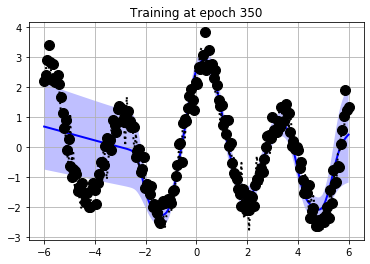

step = 351
loss =  tensor(0.9121, grad_fn=<NegBackward>)
step = 352
loss =  tensor(0.9175, grad_fn=<NegBackward>)
step = 353
loss =  tensor(0.8508, grad_fn=<NegBackward>)
step = 354
loss =  tensor(0.9132, grad_fn=<NegBackward>)
step = 355
loss =  tensor(0.8557, grad_fn=<NegBackward>)
step = 356
loss =  tensor(0.8798, grad_fn=<NegBackward>)
step = 357
loss =  tensor(0.8574, grad_fn=<NegBackward>)
step = 358
loss =  tensor(0.8907, grad_fn=<NegBackward>)
step = 359
loss =  tensor(0.8376, grad_fn=<NegBackward>)
step = 360
loss =  tensor(0.8542, grad_fn=<NegBackward>)
step = 361
loss =  tensor(0.8647, grad_fn=<NegBackward>)
step = 362
loss =  tensor(0.8166, grad_fn=<NegBackward>)
step = 363
loss =  tensor(0.8667, grad_fn=<NegBackward>)
step = 364
loss =  tensor(0.8481, grad_fn=<NegBackward>)
step = 365
loss =  tensor(0.8174, grad_fn=<NegBackward>)
step = 366
loss =  tensor(0.8177, grad_fn=<NegBackward>)
step = 367
loss =  tensor(0.8087, grad_fn=<NegBackward>)
step = 368
loss =  tensor(0.804

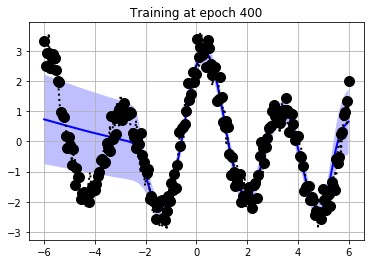

step = 401
loss =  tensor(0.8115, grad_fn=<NegBackward>)
step = 402
loss =  tensor(0.7829, grad_fn=<NegBackward>)
step = 403
loss =  tensor(0.7904, grad_fn=<NegBackward>)
step = 404
loss =  tensor(0.7763, grad_fn=<NegBackward>)
step = 405
loss =  tensor(0.7797, grad_fn=<NegBackward>)
step = 406
loss =  tensor(0.7917, grad_fn=<NegBackward>)
step = 407
loss =  tensor(0.7939, grad_fn=<NegBackward>)
step = 408
loss =  tensor(0.7817, grad_fn=<NegBackward>)
step = 409
loss =  tensor(0.7749, grad_fn=<NegBackward>)
step = 410
loss =  tensor(0.7712, grad_fn=<NegBackward>)
step = 411
loss =  tensor(0.7864, grad_fn=<NegBackward>)
step = 412
loss =  tensor(0.7542, grad_fn=<NegBackward>)
step = 413
loss =  tensor(0.7912, grad_fn=<NegBackward>)
step = 414
loss =  tensor(0.7674, grad_fn=<NegBackward>)
step = 415
loss =  tensor(0.7894, grad_fn=<NegBackward>)
step = 416
loss =  tensor(0.7652, grad_fn=<NegBackward>)
step = 417
loss =  tensor(0.7656, grad_fn=<NegBackward>)
step = 418
loss =  tensor(0.764

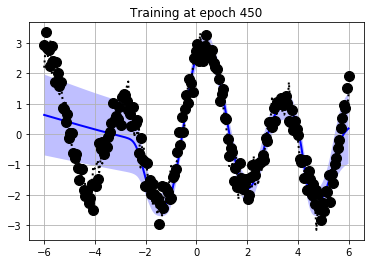

step = 451
loss =  tensor(0.8580, grad_fn=<NegBackward>)
step = 452
loss =  tensor(0.8495, grad_fn=<NegBackward>)
step = 453
loss =  tensor(0.8425, grad_fn=<NegBackward>)
step = 454
loss =  tensor(0.8556, grad_fn=<NegBackward>)
step = 455
loss =  tensor(0.8132, grad_fn=<NegBackward>)
step = 456
loss =  tensor(0.8411, grad_fn=<NegBackward>)
step = 457
loss =  tensor(0.8196, grad_fn=<NegBackward>)
step = 458
loss =  tensor(0.8204, grad_fn=<NegBackward>)
step = 459
loss =  tensor(0.8124, grad_fn=<NegBackward>)
step = 460
loss =  tensor(0.8408, grad_fn=<NegBackward>)
step = 461
loss =  tensor(0.8270, grad_fn=<NegBackward>)
step = 462
loss =  tensor(0.8098, grad_fn=<NegBackward>)
step = 463
loss =  tensor(0.7991, grad_fn=<NegBackward>)
step = 464
loss =  tensor(0.8064, grad_fn=<NegBackward>)
step = 465
loss =  tensor(0.7733, grad_fn=<NegBackward>)
step = 466
loss =  tensor(0.8162, grad_fn=<NegBackward>)
step = 467
loss =  tensor(0.8110, grad_fn=<NegBackward>)
step = 468
loss =  tensor(0.798

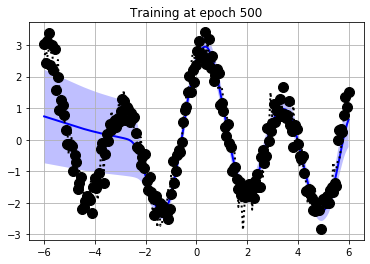

step = 501
loss =  tensor(0.8173, grad_fn=<NegBackward>)
step = 502
loss =  tensor(0.7620, grad_fn=<NegBackward>)
step = 503
loss =  tensor(0.7975, grad_fn=<NegBackward>)
step = 504
loss =  tensor(0.7822, grad_fn=<NegBackward>)
step = 505
loss =  tensor(0.7945, grad_fn=<NegBackward>)
step = 506
loss =  tensor(0.7754, grad_fn=<NegBackward>)
step = 507
loss =  tensor(0.7653, grad_fn=<NegBackward>)
step = 508
loss =  tensor(0.7544, grad_fn=<NegBackward>)
step = 509
loss =  tensor(0.7946, grad_fn=<NegBackward>)
step = 510
loss =  tensor(0.7667, grad_fn=<NegBackward>)
step = 511
loss =  tensor(0.7898, grad_fn=<NegBackward>)
step = 512
loss =  tensor(0.7689, grad_fn=<NegBackward>)
step = 513
loss =  tensor(0.7948, grad_fn=<NegBackward>)
step = 514
loss =  tensor(0.7542, grad_fn=<NegBackward>)
step = 515
loss =  tensor(0.8298, grad_fn=<NegBackward>)
step = 516
loss =  tensor(0.8735, grad_fn=<NegBackward>)
step = 517
loss =  tensor(0.8276, grad_fn=<NegBackward>)
step = 518
loss =  tensor(0.866

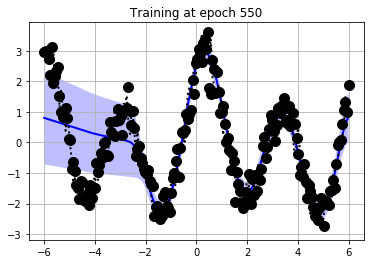

step = 551
loss =  tensor(0.7641, grad_fn=<NegBackward>)
step = 552
loss =  tensor(0.7689, grad_fn=<NegBackward>)
step = 553
loss =  tensor(0.7543, grad_fn=<NegBackward>)
step = 554
loss =  tensor(0.7692, grad_fn=<NegBackward>)
step = 555
loss =  tensor(0.7652, grad_fn=<NegBackward>)
step = 556
loss =  tensor(0.7533, grad_fn=<NegBackward>)
step = 557
loss =  tensor(0.7803, grad_fn=<NegBackward>)
step = 558
loss =  tensor(0.7523, grad_fn=<NegBackward>)
step = 559
loss =  tensor(0.7545, grad_fn=<NegBackward>)
step = 560
loss =  tensor(0.7495, grad_fn=<NegBackward>)
step = 561
loss =  tensor(0.7416, grad_fn=<NegBackward>)
step = 562
loss =  tensor(0.7676, grad_fn=<NegBackward>)
step = 563
loss =  tensor(0.7659, grad_fn=<NegBackward>)
step = 564
loss =  tensor(0.7366, grad_fn=<NegBackward>)
step = 565
loss =  tensor(0.7315, grad_fn=<NegBackward>)
step = 566
loss =  tensor(0.7495, grad_fn=<NegBackward>)
step = 567
loss =  tensor(0.7528, grad_fn=<NegBackward>)
step = 568
loss =  tensor(0.732

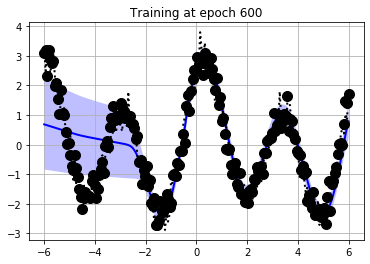

step = 601
loss =  tensor(0.8338, grad_fn=<NegBackward>)
step = 602
loss =  tensor(0.7515, grad_fn=<NegBackward>)
step = 603
loss =  tensor(0.8959, grad_fn=<NegBackward>)
step = 604
loss =  tensor(0.9024, grad_fn=<NegBackward>)
step = 605
loss =  tensor(0.8366, grad_fn=<NegBackward>)
step = 606
loss =  tensor(0.8701, grad_fn=<NegBackward>)
step = 607
loss =  tensor(0.7515, grad_fn=<NegBackward>)
step = 608
loss =  tensor(0.8036, grad_fn=<NegBackward>)
step = 609
loss =  tensor(0.7631, grad_fn=<NegBackward>)
step = 610
loss =  tensor(0.7647, grad_fn=<NegBackward>)
step = 611
loss =  tensor(0.7518, grad_fn=<NegBackward>)
step = 612
loss =  tensor(0.7719, grad_fn=<NegBackward>)
step = 613
loss =  tensor(0.7325, grad_fn=<NegBackward>)
step = 614
loss =  tensor(0.7367, grad_fn=<NegBackward>)
step = 615
loss =  tensor(0.7482, grad_fn=<NegBackward>)
step = 616
loss =  tensor(0.7314, grad_fn=<NegBackward>)
step = 617
loss =  tensor(0.7472, grad_fn=<NegBackward>)
step = 618
loss =  tensor(0.752

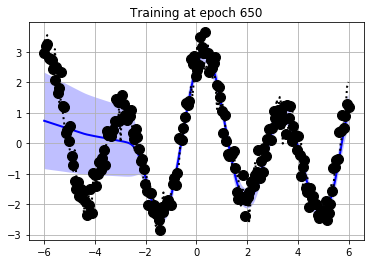

step = 651
loss =  tensor(0.7549, grad_fn=<NegBackward>)
step = 652
loss =  tensor(0.7165, grad_fn=<NegBackward>)
step = 653
loss =  tensor(0.7494, grad_fn=<NegBackward>)
step = 654
loss =  tensor(0.7386, grad_fn=<NegBackward>)
step = 655
loss =  tensor(0.7278, grad_fn=<NegBackward>)
step = 656
loss =  tensor(0.7383, grad_fn=<NegBackward>)
step = 657
loss =  tensor(0.7270, grad_fn=<NegBackward>)
step = 658
loss =  tensor(0.7365, grad_fn=<NegBackward>)
step = 659
loss =  tensor(0.7190, grad_fn=<NegBackward>)
step = 660
loss =  tensor(0.7413, grad_fn=<NegBackward>)
step = 661
loss =  tensor(0.7459, grad_fn=<NegBackward>)
step = 662
loss =  tensor(0.7376, grad_fn=<NegBackward>)
step = 663
loss =  tensor(0.7450, grad_fn=<NegBackward>)
step = 664
loss =  tensor(0.7353, grad_fn=<NegBackward>)
step = 665
loss =  tensor(0.7220, grad_fn=<NegBackward>)
step = 666
loss =  tensor(0.7199, grad_fn=<NegBackward>)
step = 667
loss =  tensor(0.7194, grad_fn=<NegBackward>)
step = 668
loss =  tensor(0.729

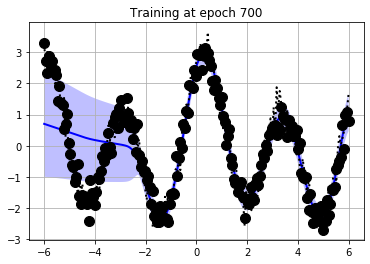

step = 701
loss =  tensor(0.8539, grad_fn=<NegBackward>)
step = 702
loss =  tensor(0.7537, grad_fn=<NegBackward>)
step = 703
loss =  tensor(0.8170, grad_fn=<NegBackward>)
step = 704
loss =  tensor(0.7977, grad_fn=<NegBackward>)
step = 705
loss =  tensor(0.8067, grad_fn=<NegBackward>)
step = 706
loss =  tensor(0.8075, grad_fn=<NegBackward>)
step = 707
loss =  tensor(0.7670, grad_fn=<NegBackward>)
step = 708
loss =  tensor(0.8234, grad_fn=<NegBackward>)
step = 709
loss =  tensor(0.7520, grad_fn=<NegBackward>)
step = 710
loss =  tensor(0.8122, grad_fn=<NegBackward>)
step = 711
loss =  tensor(0.7476, grad_fn=<NegBackward>)
step = 712
loss =  tensor(0.8044, grad_fn=<NegBackward>)
step = 713
loss =  tensor(0.7599, grad_fn=<NegBackward>)
step = 714
loss =  tensor(0.7691, grad_fn=<NegBackward>)
step = 715
loss =  tensor(0.7445, grad_fn=<NegBackward>)
step = 716
loss =  tensor(0.7548, grad_fn=<NegBackward>)
step = 717
loss =  tensor(0.7579, grad_fn=<NegBackward>)
step = 718
loss =  tensor(0.755

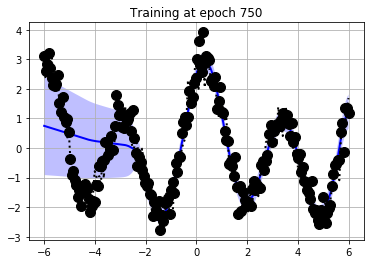

step = 751
loss =  tensor(0.7257, grad_fn=<NegBackward>)
step = 752
loss =  tensor(0.7087, grad_fn=<NegBackward>)
step = 753
loss =  tensor(0.7164, grad_fn=<NegBackward>)
step = 754
loss =  tensor(0.7214, grad_fn=<NegBackward>)
step = 755
loss =  tensor(0.7578, grad_fn=<NegBackward>)
step = 756
loss =  tensor(0.7317, grad_fn=<NegBackward>)
step = 757
loss =  tensor(0.7019, grad_fn=<NegBackward>)
step = 758
loss =  tensor(0.7214, grad_fn=<NegBackward>)
step = 759
loss =  tensor(0.7214, grad_fn=<NegBackward>)
step = 760
loss =  tensor(0.7021, grad_fn=<NegBackward>)
step = 761
loss =  tensor(0.6950, grad_fn=<NegBackward>)
step = 762
loss =  tensor(0.7238, grad_fn=<NegBackward>)
step = 763
loss =  tensor(0.7268, grad_fn=<NegBackward>)
step = 764
loss =  tensor(0.7118, grad_fn=<NegBackward>)
step = 765
loss =  tensor(0.7069, grad_fn=<NegBackward>)
step = 766
loss =  tensor(0.7067, grad_fn=<NegBackward>)
step = 767
loss =  tensor(0.7353, grad_fn=<NegBackward>)
step = 768
loss =  tensor(0.723

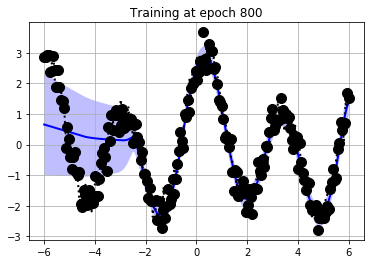

step = 801
loss =  tensor(0.7136, grad_fn=<NegBackward>)
step = 802
loss =  tensor(0.7035, grad_fn=<NegBackward>)
step = 803
loss =  tensor(0.6948, grad_fn=<NegBackward>)
step = 804
loss =  tensor(0.7296, grad_fn=<NegBackward>)
step = 805
loss =  tensor(0.7115, grad_fn=<NegBackward>)
step = 806
loss =  tensor(0.7017, grad_fn=<NegBackward>)
step = 807
loss =  tensor(0.7478, grad_fn=<NegBackward>)
step = 808
loss =  tensor(0.7616, grad_fn=<NegBackward>)
step = 809
loss =  tensor(0.7308, grad_fn=<NegBackward>)
step = 810
loss =  tensor(0.7135, grad_fn=<NegBackward>)
step = 811
loss =  tensor(0.7249, grad_fn=<NegBackward>)
step = 812
loss =  tensor(0.6838, grad_fn=<NegBackward>)
step = 813
loss =  tensor(0.7146, grad_fn=<NegBackward>)
step = 814
loss =  tensor(0.6851, grad_fn=<NegBackward>)
step = 815
loss =  tensor(0.6991, grad_fn=<NegBackward>)
step = 816
loss =  tensor(0.6795, grad_fn=<NegBackward>)
step = 817
loss =  tensor(0.6853, grad_fn=<NegBackward>)
step = 818
loss =  tensor(0.679

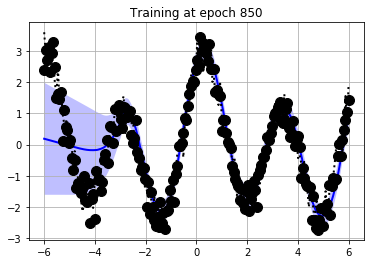

step = 851
loss =  tensor(0.6488, grad_fn=<NegBackward>)
step = 852
loss =  tensor(0.6590, grad_fn=<NegBackward>)
step = 853
loss =  tensor(0.6640, grad_fn=<NegBackward>)
step = 854
loss =  tensor(0.6746, grad_fn=<NegBackward>)
step = 855
loss =  tensor(0.6642, grad_fn=<NegBackward>)
step = 856
loss =  tensor(0.6483, grad_fn=<NegBackward>)
step = 857
loss =  tensor(0.6822, grad_fn=<NegBackward>)
step = 858
loss =  tensor(0.6551, grad_fn=<NegBackward>)
step = 859
loss =  tensor(0.6680, grad_fn=<NegBackward>)
step = 860
loss =  tensor(0.6743, grad_fn=<NegBackward>)
step = 861
loss =  tensor(0.6300, grad_fn=<NegBackward>)
step = 862
loss =  tensor(0.6452, grad_fn=<NegBackward>)
step = 863
loss =  tensor(0.6532, grad_fn=<NegBackward>)
step = 864
loss =  tensor(0.6426, grad_fn=<NegBackward>)
step = 865
loss =  tensor(0.6851, grad_fn=<NegBackward>)
step = 866
loss =  tensor(0.6560, grad_fn=<NegBackward>)
step = 867
loss =  tensor(0.6243, grad_fn=<NegBackward>)
step = 868
loss =  tensor(0.649

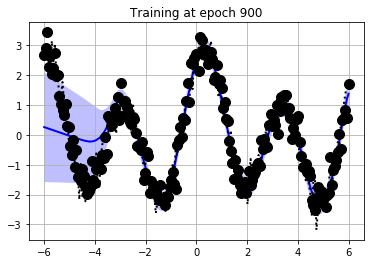

step = 901
loss =  tensor(0.6363, grad_fn=<NegBackward>)
step = 902
loss =  tensor(0.6229, grad_fn=<NegBackward>)
step = 903
loss =  tensor(0.6288, grad_fn=<NegBackward>)
step = 904
loss =  tensor(0.5890, grad_fn=<NegBackward>)
step = 905
loss =  tensor(0.6212, grad_fn=<NegBackward>)
step = 906
loss =  tensor(0.6225, grad_fn=<NegBackward>)
step = 907
loss =  tensor(0.6209, grad_fn=<NegBackward>)
step = 908
loss =  tensor(0.6230, grad_fn=<NegBackward>)
step = 909
loss =  tensor(0.6045, grad_fn=<NegBackward>)
step = 910
loss =  tensor(0.6483, grad_fn=<NegBackward>)
step = 911
loss =  tensor(0.6251, grad_fn=<NegBackward>)
step = 912
loss =  tensor(0.6302, grad_fn=<NegBackward>)
step = 913
loss =  tensor(0.6184, grad_fn=<NegBackward>)
step = 914
loss =  tensor(0.6113, grad_fn=<NegBackward>)
step = 915
loss =  tensor(0.5764, grad_fn=<NegBackward>)
step = 916
loss =  tensor(0.6012, grad_fn=<NegBackward>)
step = 917
loss =  tensor(0.5869, grad_fn=<NegBackward>)
step = 918
loss =  tensor(0.593

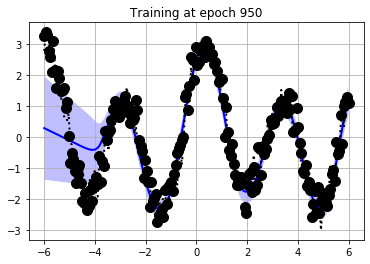

step = 951
loss =  tensor(0.6020, grad_fn=<NegBackward>)
step = 952
loss =  tensor(0.6242, grad_fn=<NegBackward>)
step = 953
loss =  tensor(0.6090, grad_fn=<NegBackward>)
step = 954
loss =  tensor(0.6350, grad_fn=<NegBackward>)
step = 955
loss =  tensor(0.6022, grad_fn=<NegBackward>)
step = 956
loss =  tensor(0.6069, grad_fn=<NegBackward>)
step = 957
loss =  tensor(0.5881, grad_fn=<NegBackward>)
step = 958
loss =  tensor(0.6196, grad_fn=<NegBackward>)
step = 959
loss =  tensor(0.5872, grad_fn=<NegBackward>)
step = 960
loss =  tensor(0.6092, grad_fn=<NegBackward>)
step = 961
loss =  tensor(0.5907, grad_fn=<NegBackward>)
step = 962
loss =  tensor(0.6066, grad_fn=<NegBackward>)
step = 963
loss =  tensor(0.6195, grad_fn=<NegBackward>)
step = 964
loss =  tensor(0.6538, grad_fn=<NegBackward>)
step = 965
loss =  tensor(0.6052, grad_fn=<NegBackward>)
step = 966
loss =  tensor(0.6292, grad_fn=<NegBackward>)
step = 967
loss =  tensor(0.6177, grad_fn=<NegBackward>)
step = 968
loss =  tensor(0.652

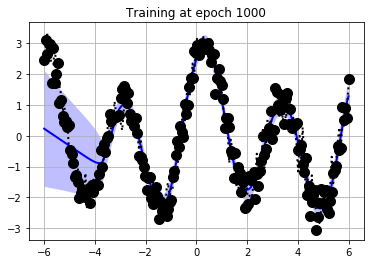

In [16]:
print("Training...")

for epoch in range(1, num_epochs + 1):
    print("step = " + str(epoch))

    np_model.train()

    plt.clf()
    optim.zero_grad()

    ctt_x, ctt_y, tgt_x, tgt_y = data.query(batch_size=batch_size,
                                            context_x_start=-6,
                                            context_x_end=6,
                                            context_x_num=200,
                                            target_x_start=-6,
                                            target_x_end=6,
                                            target_x_num=200)

    mu, sigma, log_p, kl, loss = np_model(ctt_x, ctt_y, tgt_x, tgt_y)

    print('loss = ', loss)
    loss.backward()
    optim.step()
    np_model.eval()
    
    if epoch % 50 == 0:
        plt.ion()
        plot_functions(tgt_x.numpy(),
                       tgt_y.numpy(),
                       ctt_x.numpy(),
                       ctt_y.numpy(),
                       mu.detach().numpy(),
                       sigma.detach().numpy())
        title_str = 'Training at epoch ' + str(epoch)
        plt.title(title_str)
        plt.pause(0.1)

plt.ioff()
plt.show()